# Risk Factor Clinical Classifier

This classifier takes patient answers to the Lung Space clinical survey and predicts the chance of cancer.

## Import dataset and build dataframe

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

df = pd.read_csv('../data/lungspace/package-nlst-1193.2024-02-20/participant_d040722.csv')


# Breakdown of positive and negative sample size
print("positive: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 1].to_list()), " negative: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 0].to_list()))

# Features
features_demographic = ['age', 'weight', 'height']
features_smoking = ["cigar","cigsmok","pipe","pkyr","smokeage","smokeday","smokelive","smokework","smokeyr"]
features_screening = ['num_screens']
features_follow_up_procedures = ["biop0","biop1","biop2","bioplc","invas0","invas1","invas2","invaslc","medcomp0","medcomp1","medcomp2","medcomplc","mra_stat0","mra_stat1","mra_stat2","no_proc_reas0","no_proc_reas1","no_proc_reas2","proc0","proc1","proc2"]
features_work_history = ["resasbe","resbaki","resbutc","reschem","resfarm","resfire","resflou","resfoun","reshard","respain","ressand","resweld","wrkasbe","wrkbaki","wrkbutc","wrkchem","wrkcoal","wrkcott","wrkfarm","wrkfire","wrkflou","wrkfoun","wrkhard","wrkpain","wrksand","wrkweld"]
features_disease_history = ["ageadas","ageasbe","agebron","agechas","agechro","agecopd","agediab","ageemph","agehear","agehype","agepneu","agestro","agetube","diagadas","diagasbe","diagbron","diagchas","diagchro","diagcopd","diagdiab","diagemph","diagfibr","diaghear","diaghype","diagpneu","diagsarc","diagsili","diagstro","diagtube"]
features_family_history = ["fambrother","famchild","famfather","fammother","famsister"]
features_alcohol = ["acrin_alc_curr","acrin_alc_ever","acrin_drink24hr","acrin_drinknum_curr","acrin_drinknum_form","acrin_drinkyrs_curr","acrin_drinkyrs_form","acrin_lastdrink","lss_alcohol_freq","lss_alcohol_num"]
output_column = ['lung_cancer']

# All columns to
# dataset_columns = features_demographic + features_smoking + features_screening + features_work_history + features_disease_history + features_family_history + features_alcohol + output_column
dataset_columns = features_demographic + features_smoking + features_screening + output_column

# Build dataframe
df = df[dataset_columns]
for i in dataset_columns[:]:
  if df[i].isna().sum() > 500:
    df = df.drop(i, axis=1)
    dataset_columns.remove(i)

# print(df.isnull().sum(axis = 0).sort_values(ascending=False).to_string())

df = df.dropna()


positive:  2058  negative:  51394


/tmp/ipykernel_7465/944167057.py:8: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/lungspace/package-nlst-1193.2024-02-20/participant_d040722.csv')


In [2]:
# # Determines how many negative samples to include in the dataset
# # The frac value determines the percent of negative values that are excluded
# df = df.drop(df.query('lung_cancer == 0').sample(frac=.95).index)

# df = df[df[dataset_columns] >= 0]
# # print(df.loc[df.apply(lambda row: all(value < 0 for value in row), axis=1)])
# df = df.dropna()
# print(df)


In [3]:
df_positives = df[df['lung_cancer'] == 1]
print(df_positives)
print(len(df_positives['lung_cancer'].to_list()))

while len(df[df['lung_cancer'] == 1]['lung_cancer'].to_list()) < len(df[df['lung_cancer'] == 0]['lung_cancer'].to_list()):
  df = pd.concat([df, df_positives])

print(df)
print("positive: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 1].to_list()), " negative: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 0].to_list()))


       age  weight  height  cigar  cigsmok  pipe  pkyr  smokeage  smokeday  \
11      61   142.0    67.0    1.0        1   1.0  37.0      22.0        20   
48      74   190.0    71.0    0.0        1   0.0  54.0      20.0        20   
54      67   165.0    70.0    0.0        0   0.0  48.0      19.0        20   
157     65   189.0    68.0    0.0        0   0.0  94.0      14.0        40   
195     65   159.0    62.0    0.0        1   0.0  45.0      20.0        20   
...    ...     ...     ...    ...      ...   ...   ...       ...       ...   
53381   60   169.0    65.0    0.0        0   1.0  88.0      15.0        40   
53391   69   135.0    65.0    0.0        1   0.0  50.0      17.0        20   
53395   56   195.0    70.0    0.0        1   0.0  60.0      16.0        30   
53430   61   190.0    72.0    0.0        0   0.0  67.5      16.0        30   
53443   57   230.0    64.0    0.0        0   0.0  37.0      16.0        20   

       smokelive  smokework  smokeyr  num_screens  lung_cancer 

## Define models

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Model names
names = [
    "Nearest Neighbors",
    "Linear SVM",
    # "RBF SVM",
    # "Gaussian Process",
    "Decision Tree",
    # "Random Forest",
    # "Neural Net",
    # "AdaBoost",
    "Naive Bayes",
    "Logistic Regression"
    # "QDA",
]

# Models
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    # SVC(gamma=2, C=1, random_state=42),
    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    # RandomForestClassifier(
    #     max_depth=5, n_estimators=10, max_features=1, random_state=42
    # ),
    # MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    # AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    LogisticRegression(random_state=0)
    # QuadraticDiscriminantAnalysis(),
]


# Use predict lung_cancer column
# X = df[['age', 'weight', 'height', "cigar","cigsmok","pipe","pkyr","smokeage","smokeday","smokelive","smokework","smokeyr","num_screens"]]
X = df[dataset_columns[:-1]]
y = df[['lung_cancer']]

# Spli training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

print(y_train)
print(y_test)

print("positive training sample: ", len(list(filter(lambda x: x == 1.0, y_train['lung_cancer'].to_list()))))
print("negative training sample: ", len(list(filter(lambda x: x == 0.0, y_train['lung_cancer'].to_list()))))
print("positive training sample: ", len(list(filter(lambda x: x == 1.0, y_test['lung_cancer'].to_list()))))
print("negative training sample: ", len(list(filter(lambda x: x == 0.0, y_test['lung_cancer'].to_list()))))


       lung_cancer
44069            1
13561            1
28305            0
48039            0
37945            1
...            ...
6437             0
11211            1
7129             1
885              0
16216            0

[61597 rows x 1 columns]
       lung_cancer
45168            1
1925             0
21895            1
6402             0
46969            1
...            ...
7533             1
28221            0
23119            1
44556            1
20604            0

[41066 rows x 1 columns]
positive training sample:  31337
negative training sample:  30260
positive training sample:  20871
negative training sample:  20195


## Test models and plot confusion matrices

The goal is to minimize the number of false negative predictions.

In [5]:
# for name, clf in zip(names, classifiers):
#   clf = make_pipeline(StandardScaler(), clf)
#   clf.fit(normalize(X_train), y_train)
#   y_pred = clf.predict(normalize(X_test))

#   score = accuracy_score(y_test, y_pred)
#   conf_matrix = confusion_matrix(y_test, y_pred)
#   disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
#   disp.plot()
#   print("Model: ", name, " score: ", score)


## Get confidence of each prediction with `predict_proba()`

/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model:  Logistic Regression  score:  0.6995811620318512


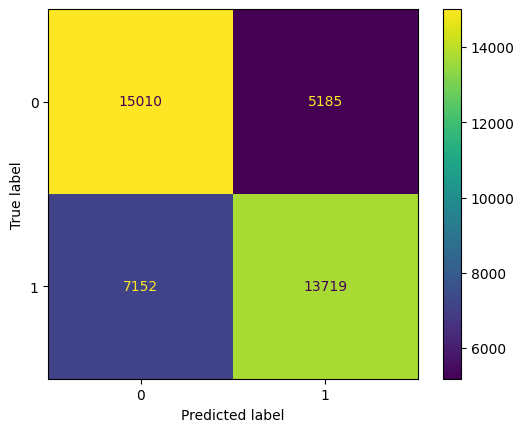

In [6]:
# # Fit logistic regression model
# model = LogisticRegression(random_state=0)
# model.fit(X_train, y_train)

# # Get confidence intervals for each prediction
# y_pred_prob = model.predict_proba(X_test)
# # Get predicted values
# y_pred = model.predict(normalize(X_test))

# # Get prediction accuracy
# score = accuracy_score(y_test, y_pred)
# # Get breakdown of false/true positives and false/true negatives
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Display results
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
# disp.plot()
# print("Model: ", name, " score: ", score)

clf = m = LogisticRegression(random_state=0)
clf = make_pipeline(StandardScaler(), clf)
clf.fit(normalize(X_train), y_train)
y_pred = clf.predict(normalize(X_test))
y_pred_prob = clf.predict_proba(X_test)

score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
print("Model: ", "Logistic Regression", " score: ", score)


## Rank features used 

In [7]:
# Create lists of feature names and coefficients
column_labels = X_train.columns.tolist()
coef = m.coef_.squeeze().tolist()

# Zip together
labels_coef = list(zip(column_labels, coef))
# Order by most significant features (positive or negative)
feature_ranks = sorted(labels_coef, key=lambda x: abs(x[1]), reverse=True)

print(feature_ranks)


[('pkyr', 1.1793188797939647), ('num_screens', -0.9098852914156167), ('weight', 0.6880863311819253), ('age', 0.5570335553403755), ('smokeday', -0.3413325349810165), ('smokeyr', 0.2808197766307373), ('height', 0.15303303960792417), ('cigsmok', 0.10739085446708116), ('smokeage', 0.09221707874127914), ('smokework', 0.055991954259029635), ('cigar', 0.0034699631141755388), ('smokelive', 0.0004919781469341076), ('pipe', 0.00048146858391345554)]


## Compare compare the probabilities of false positives and false negatives to true positives and true negatives

In [8]:
true_negative_probs = []
false_negative_probs = []
true_positive_probs = []
false_positive_probs = []

y_pred_list = y_pred.tolist()
y_pred_prob_list = y_pred_prob.tolist()
y_test_list = y_test['lung_cancer'].tolist()

for i in range(len(y_test)):
  # true negative
  if y_pred_list[i] == 0 and y_test_list[i] == 0:
    true_negative_probs.append(y_pred_prob_list[i][0])
  # false negative
  elif y_pred_list[i] == 0 and y_test_list[i] == 1:
    false_negative_probs.append(y_pred_prob_list[i][0])
  # true positive
  elif y_pred_list[i] == 1 and y_test_list[i] == 1:
    true_positive_probs.append(y_pred_prob_list[i][1])
  # false positive
  else:
    false_positive_probs.append(y_pred_prob_list[i][1])


## Plot the confidence intervals that led to the different predictions. 

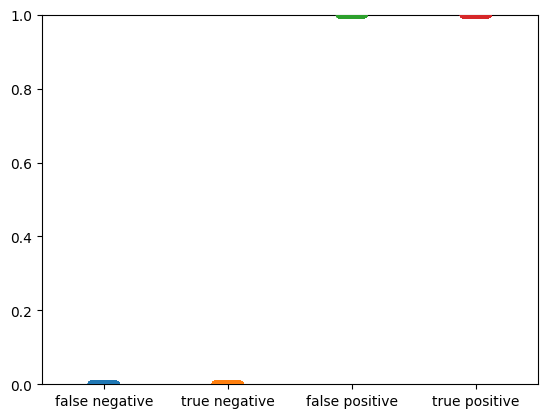

In [9]:
data = {'false negative': false_negative_probs,
               'true negative': true_negative_probs,
               'false positive': false_positive_probs,
               'true positive': true_positive_probs,
              }
cols = ['false negative', 'true negative', 'false positive', 'true positive']

df = pd.DataFrame.from_dict(
    data=dict(data),
    orient='index',
).T

fig, ax = plt.subplots()

ax = sns.stripplot(data=df)
ax.set_ylim(0, 1)

plt.show()


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model:  KNN  score:  0.9496907417328203


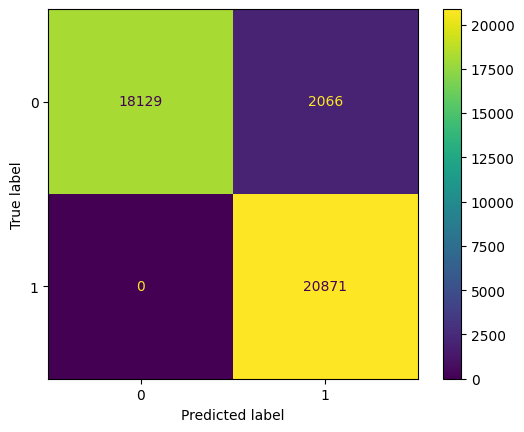

In [10]:
clf = KNeighborsClassifier(3)
clf = make_pipeline(StandardScaler(), clf)
clf.fit(normalize(X_train), y_train)
y_pred = clf.predict(normalize(X_test))
y_pred_prob = clf.predict_proba(X_test)

score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
print("Model: ", "KNN", " score: ", score)

# # Fit logistic regression model
# model2 = KNeighborsClassifier(3)
# model2.fit(X_train, y_train)

# # Get confidence intervals for each prediction
# y_pred_prob = model2.predict_proba(X_test)
# # Get predicted values
# y_pred = model2.predict(normalize(X_test))

# # Get prediction accuracy
# score = accuracy_score(y_test, y_pred)
# # Get breakdown of false/true positives and false/true negatives
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Display results
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
# disp.plot()
# print("Model: ", "KNN", " score: ", score)


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model:  Random Forest  score:  0.9946184191301807


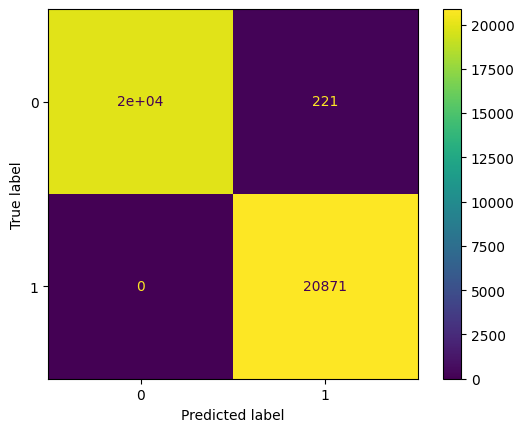

In [11]:
clf = m = RandomForestClassifier()
clf = make_pipeline(StandardScaler(), clf)
clf.fit(normalize(X_train), y_train)
y_pred = clf.predict(normalize(X_test))
y_pred_prob = clf.predict_proba(X_test)

score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
print("Model: ", "Random Forest", " score: ", score)


In [12]:
# Create lists of feature names and coefficients
column_labels = X_train.columns.tolist()
coef = m.feature_importances_

# Zip together
labels_coef = list(zip(column_labels, coef))
# Order by most significant features (positive or negative)
feature_ranks = sorted(labels_coef, key=lambda x: abs(x[1]), reverse=True)

print(feature_ranks)


[('num_screens', 0.18915210625828283), ('pkyr', 0.10058166588651908), ('smokeyr', 0.09905802421167334), ('weight', 0.08978483019732283), ('age', 0.08311213243648019), ('height', 0.07700878685062366), ('smokeage', 0.07692459361544483), ('smokeday', 0.07380677221941119), ('smokelive', 0.062110445665537556), ('smokework', 0.059214349774272465), ('cigsmok', 0.04477808592500675), ('pipe', 0.023320626513378247), ('cigar', 0.021147580446047)]


In [13]:
true_negative_probs = []
false_negative_probs = []
true_positive_probs = []
false_positive_probs = []

y_pred_list = y_pred.tolist()
y_pred_prob_list = y_pred_prob.tolist()
y_test_list = y_test['lung_cancer'].tolist()

for i in range(len(y_test)):
  # true negative
  if y_pred_list[i] == 0 and y_test_list[i] == 0:
    true_negative_probs.append(y_pred_prob_list[i][0])
  # false negative
  elif y_pred_list[i] == 0 and y_test_list[i] == 1:
    false_negative_probs.append(y_pred_prob_list[i][0])
  # true positive
  elif y_pred_list[i] == 1 and y_test_list[i] == 1:
    true_positive_probs.append(y_pred_prob_list[i][1])
  # false positive
  else:
    false_positive_probs.append(y_pred_prob_list[i][1])


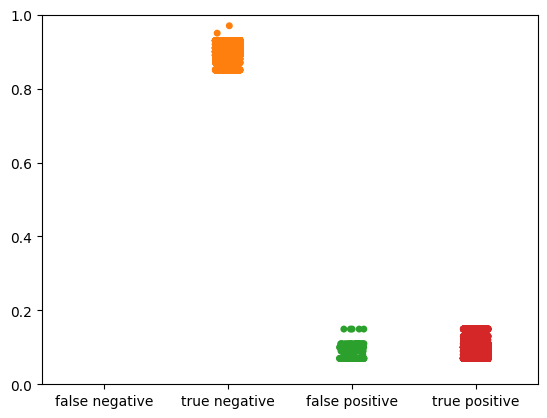

In [14]:
data = {'false negative': false_negative_probs,
               'true negative': true_negative_probs,
               'false positive': false_positive_probs,
               'true positive': true_positive_probs,
              }
cols = ['false negative', 'true negative', 'false positive', 'true positive']

df = pd.DataFrame.from_dict(
    data=dict(data),
    orient='index',
).T

fig, ax = plt.subplots()

ax = sns.stripplot(data=df)
ax.set_ylim(0, 1)

plt.show()


In [15]:
# from sklearn.svm import OneClassSVM

# clf = OneClassSVM(gamma='auto').fit(X_train)

# output = clf.predict(X_train)

# print()


In [16]:
# print(output)

# print(len(output))
# print(len(y_train))

# print(y_train)

# false_pos = 0
# false_neg = 0
# true_pos = 0
# true_neg = 0

# for i in range(len(output)):
#   if output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 0:
#     true_neg += 1
#   elif output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 1:
#     false_neg += 1
#   elif output[i] == -1 and y_train.iloc[i]['lung_cancer'] == 0:
#     false_pos += 1
#   else:
#     true_pos += 1

# print("false_pos: ", false_pos, " true_pos ", true_pos, " false_neg ", false_neg, " true_neg ", true_neg)


In [17]:
# scores = clf.score_samples(X_train)


In [18]:
# print(sorted(scores, reverse=True))

# new_output = output[:]

# for i in range(len(new_output)):
#   if scores[i] < 2 and new_output[i] == -1:
#     new_output[i] = 1
#   elif scores[i] >= 2 and new_output[i] == 1:
#     new_output[i] = -1

# false_pos = 0
# false_neg = 0
# true_pos = 0
# true_neg = 0

# for i in range(len(output)):
#   if new_output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 0:
#     true_neg += 1
#   elif new_output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 1:
#     false_neg += 1
#   elif new_output[i] == -1 and y_train.iloc[i]['lung_cancer'] == 0:
#     false_pos += 1
#   else:
#     true_pos += 1

# print("false_pos: ", false_pos, " true_pos ", true_pos, " false_neg ", false_neg, " true_neg ", true_neg)
